In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import adjusted_rand_score, confusion_matrix

import umap
import hdbscan

c:\Users\jonas\anaconda3\envs\fysstk3155\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Component Reduction UMAP 150 Chunk Size

In [3]:
X = np.load('Data/text_data150.npy')
y = np.load('Data/labels150.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

# Helpers
def sort_matrix(matrix):
    """Reorders the design matrix for ease of reading - note that no information is added"""
    return matrix[:,np.argmax(matrix, axis=1)]

def plot_confusion_matrix(cm, title):
    if len(cm) == 5:
        fs = 12
        ticks = ['Austen', 'Dostoyevsky', 'God', 'Cervantes', 'Sturluson']
    else:
        fs = 10
        ticks = ['Unlabled', 'Austen', 'Dostoyevsky', 'God', 'Cervantes', 'Sturluson']

    ax = sns.heatmap(cm, 
            annot=True,
            annot_kws={"fontsize":fs},
            fmt=".0f",
            xticklabels=ticks,
            yticklabels=ticks,
            cmap='crest')
    plt.ylabel('True label', fontsize=13)
    plt.title(title, fontsize=17, pad=20, loc='center')
    ax.set(xlabel="", ylabel="True label")
    ax.xaxis.tick_top()

    plt.gca().figure.text(0.45, 0.05, 'Predicted label', ha='center', fontsize=13)
    plt.show()

Dimension: 2


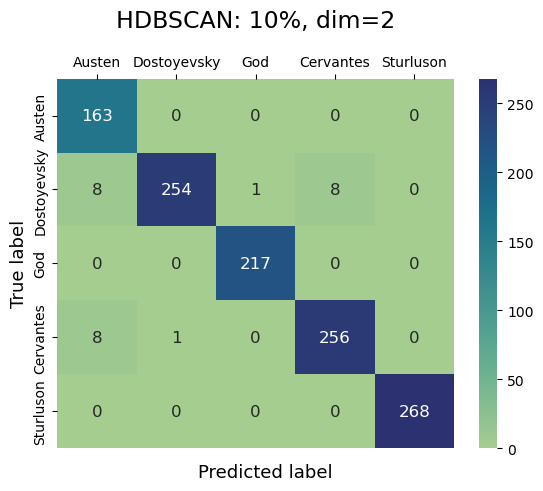

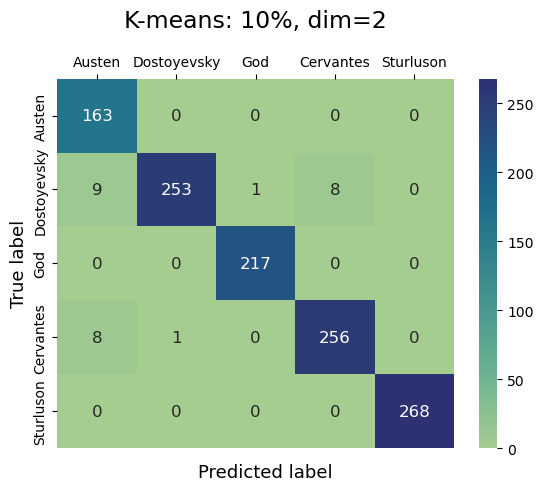

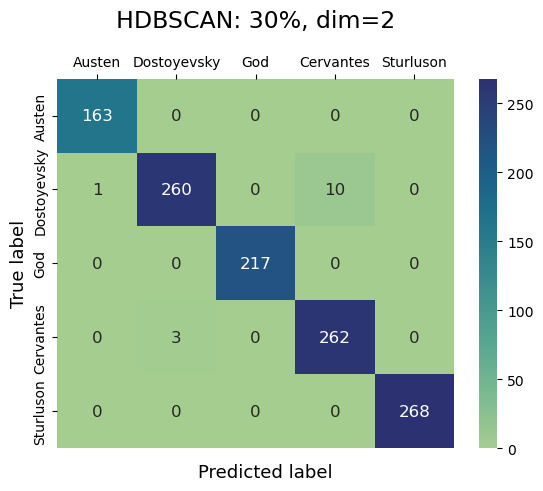

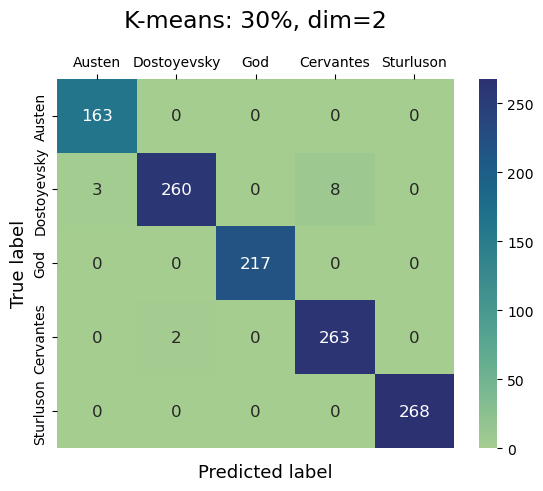

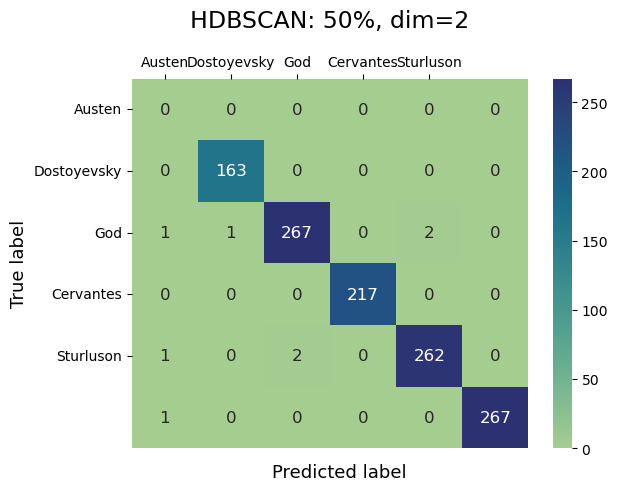

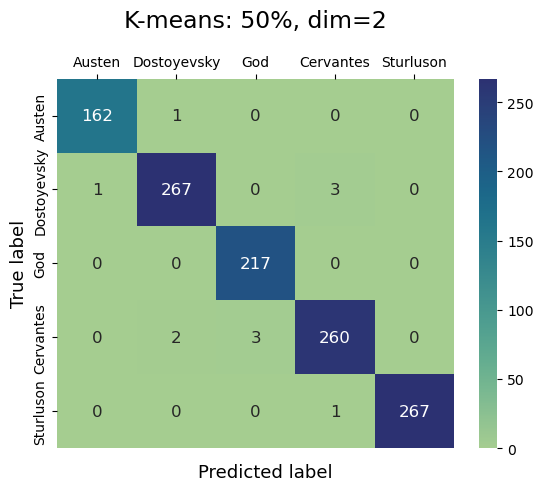

Dimension: 16


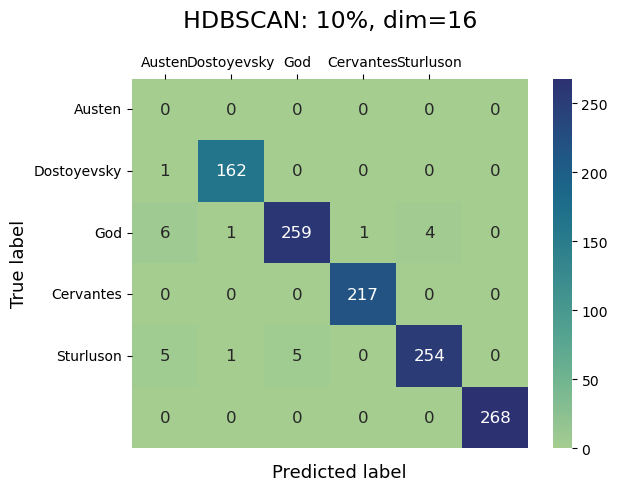

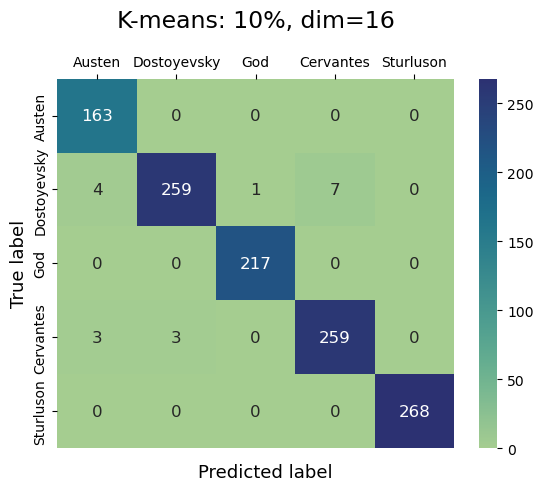

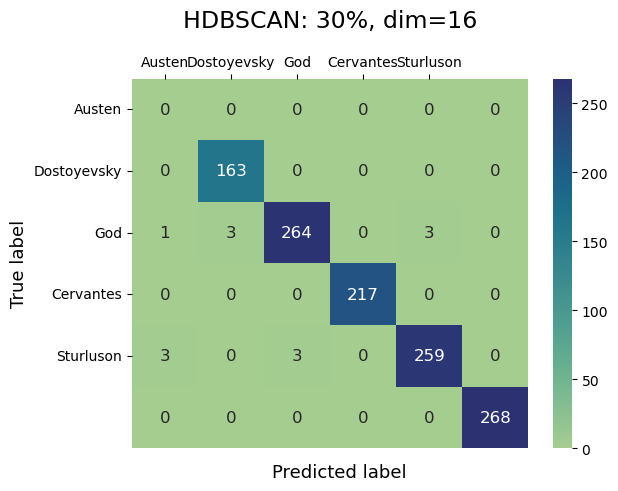

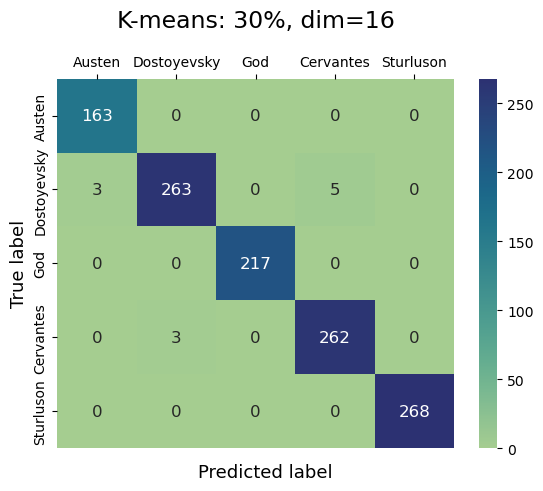

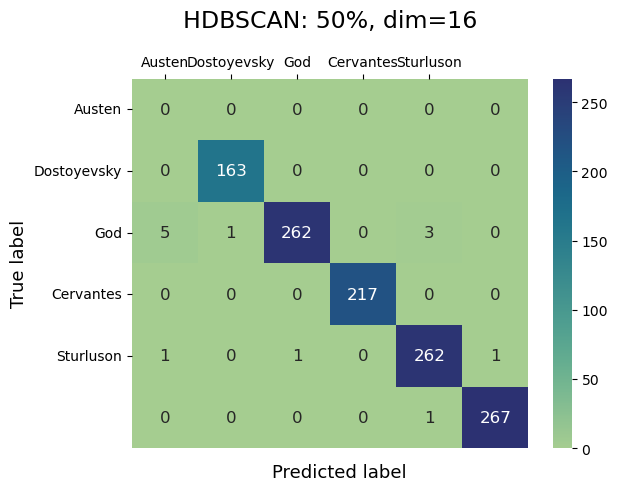

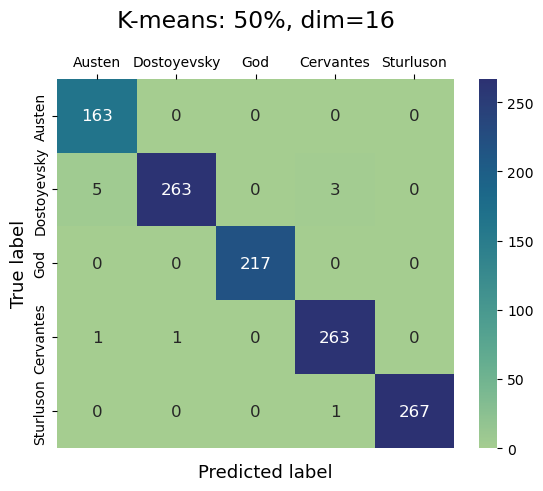

Dimension: 128


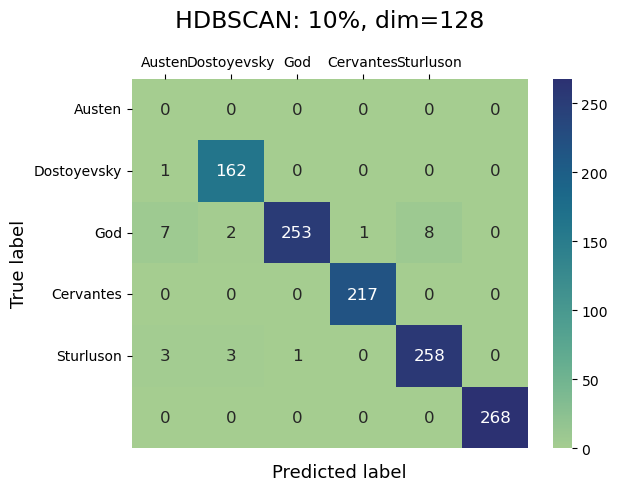

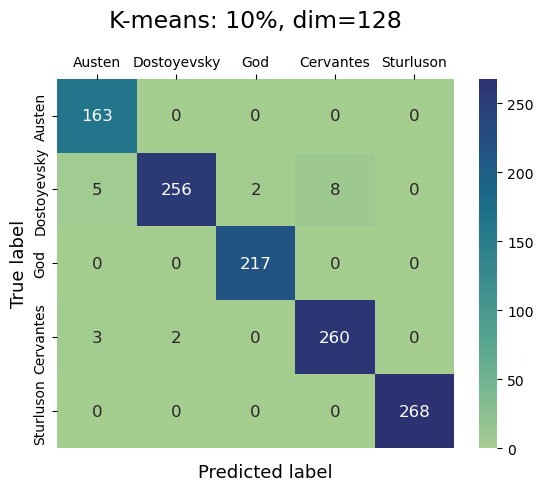

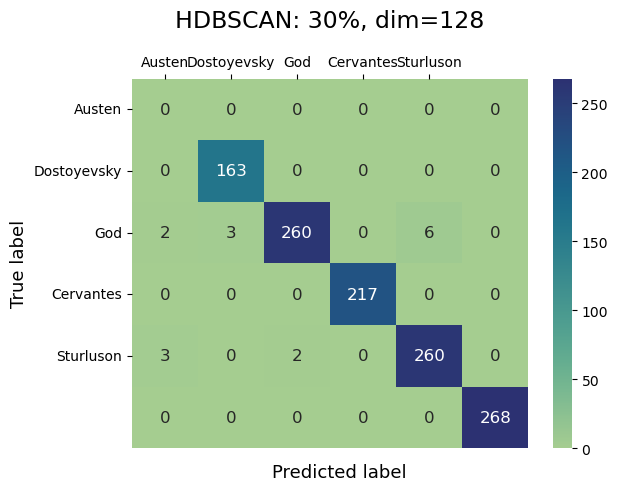

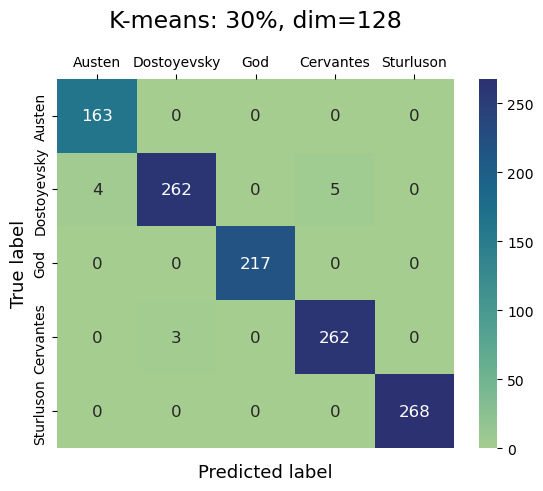

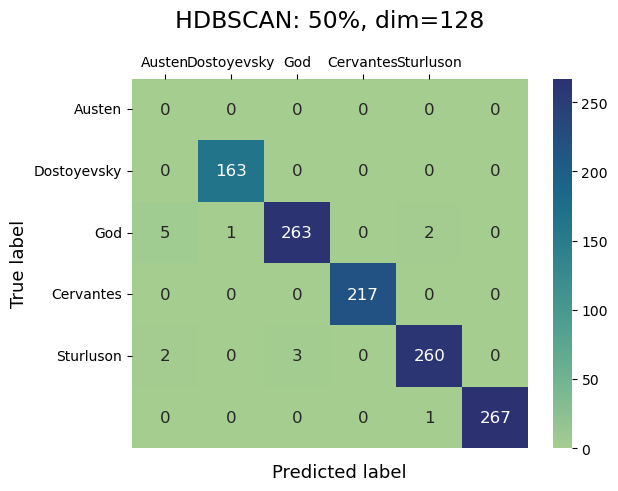

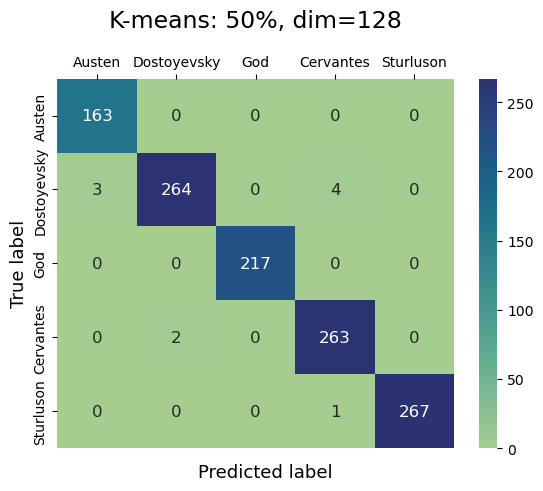

In [31]:
sizes = [1, 3, 5, 10]
dimensions = [2, 16, 128]

for idy, dim in enumerate(dimensions):
    print(f'Dimension: {dim}')
    for idx, size in enumerate(sizes):
        X_t2, X_val, y_t2, y_val = train_test_split(X_train, y_train, test_size=size/10, stratify=y_train, random_state=3)

        # reducing dimensions with labeled data (size*10 % training data)
        mapper = umap.UMAP(n_neighbors=30,
                            min_dist=0.0,
                            init='random',
                            metric='euclidean',
                            n_components=dim).fit(X_val, y=y_val)
        embedding_train = mapper.transform(X_train)
        embedding_test = mapper.transform(X_test)

        # fitting hdbscan and kmeans and plottig CMs
        hdb = hdbscan.HDBSCAN(
            min_cluster_size=500,
            min_samples=1,
            prediction_data=True
        ).fit(embedding_train)
        hdbpred, _strengths = hdbscan.approximate_predict(hdb, embedding_test)
        plot_confusion_matrix(sort_matrix(confusion_matrix(y_test, hdbpred)), f'HDBSCAN: {size*10}%, dim={dim}')
    
        kmeans = KMeans(n_clusters=5, random_state=3).fit(embedding_train)
        pred = kmeans.predict(embedding_test)
        plot_confusion_matrix(sort_matrix(confusion_matrix(y_test, pred)), f'K-means: {size*10}%, dim={dim}')



## Now sentences

In [4]:
X = np.load('Data/text_data_sentences.npy')
y = np.load('Data/labels_sentences.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=3)

Dimension: 2


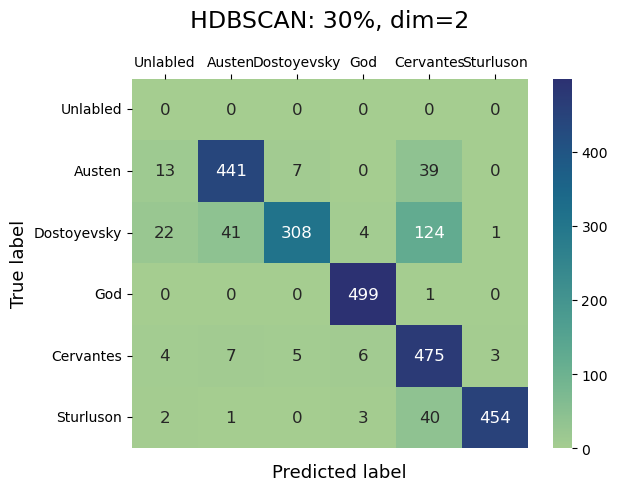

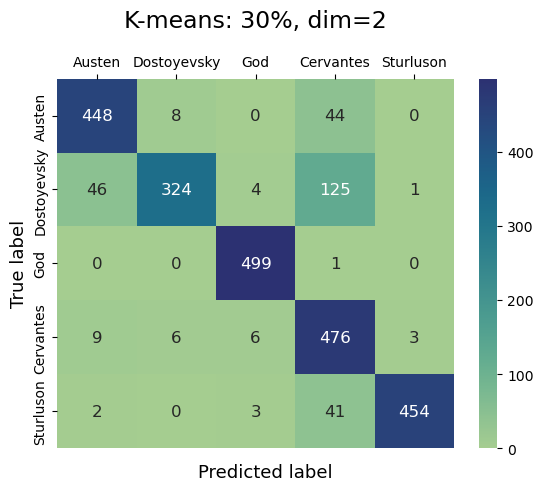

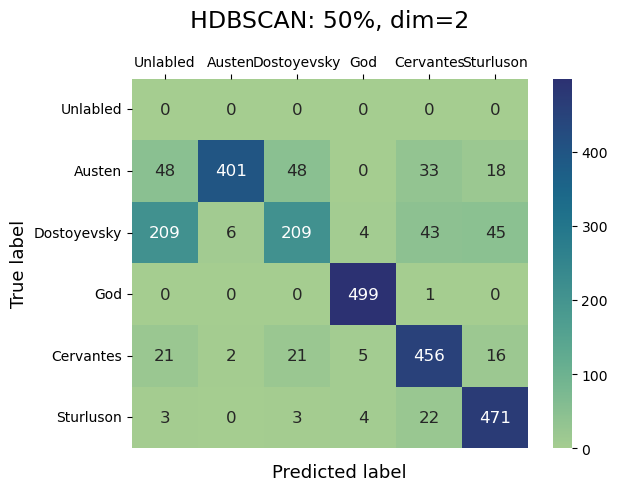

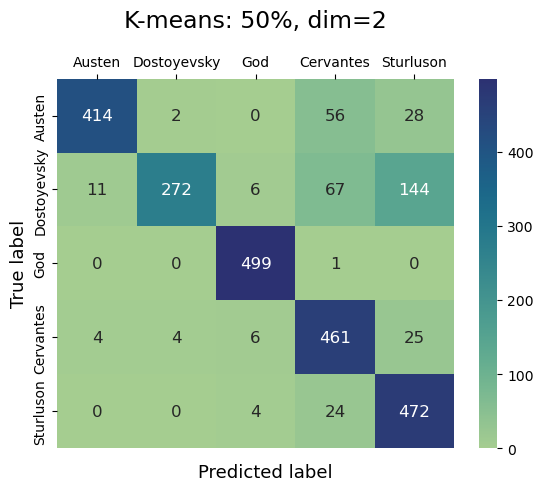

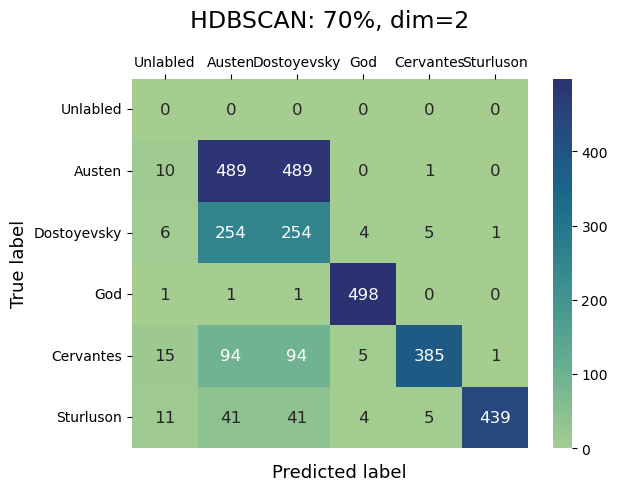

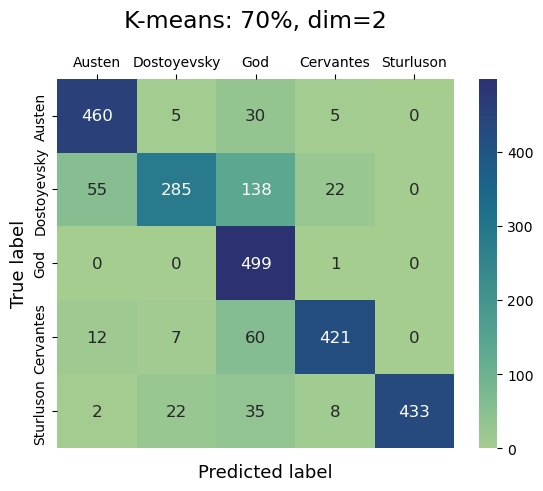

Dimension: 16


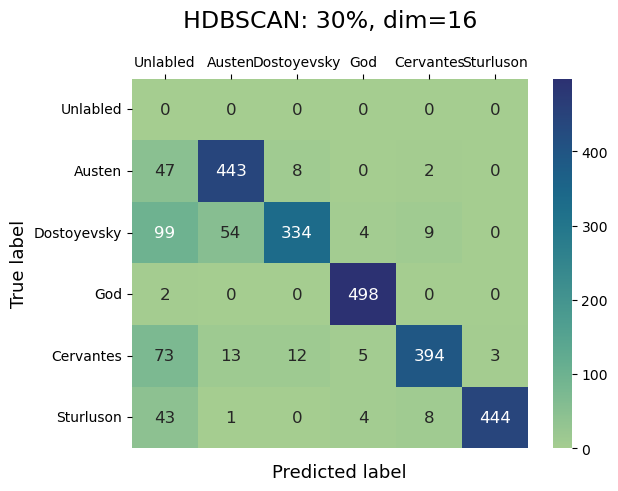

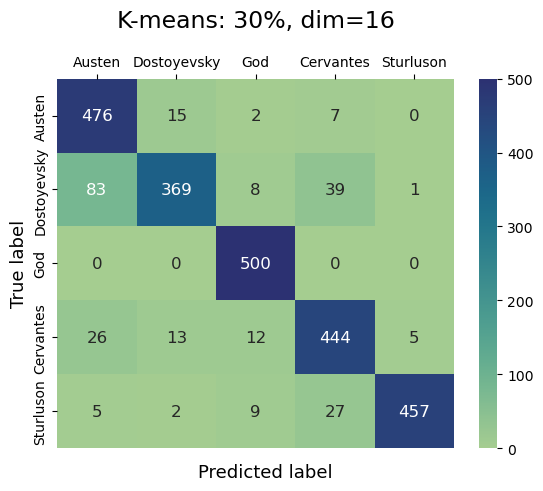

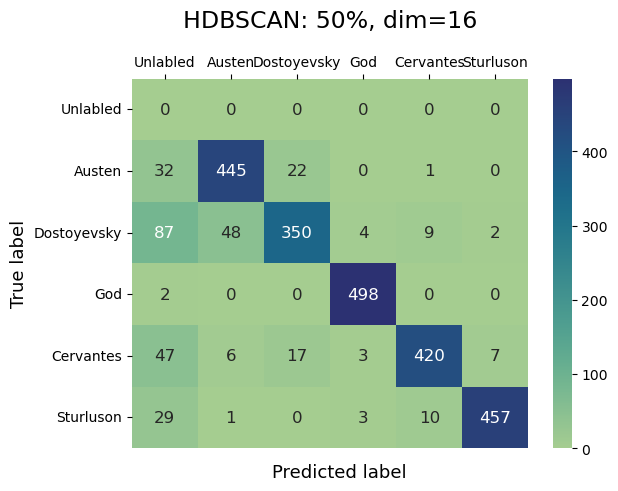

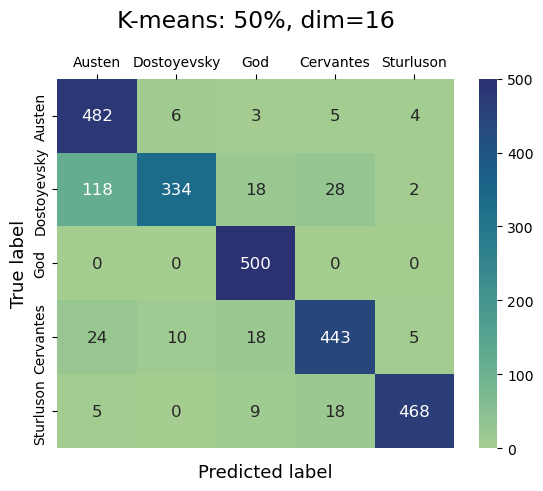

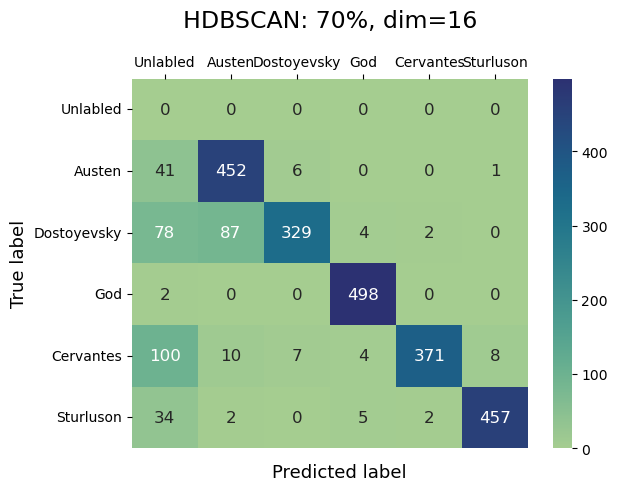

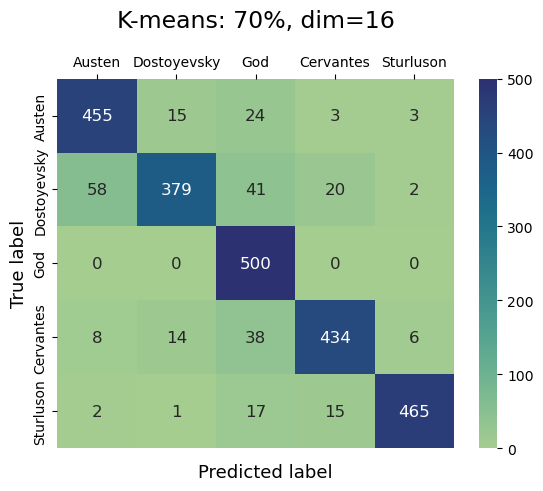

Dimension: 128


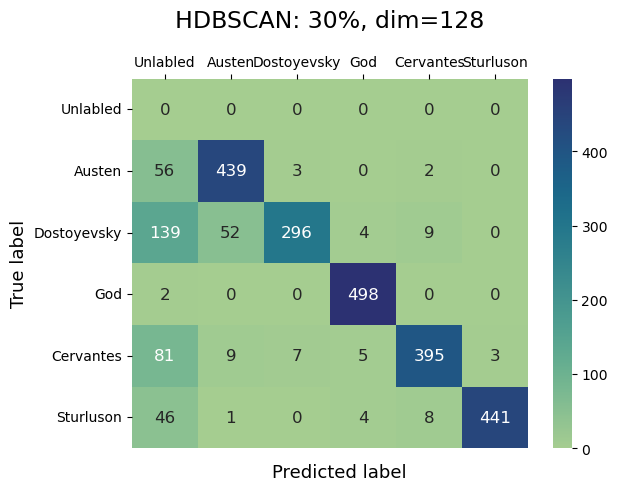

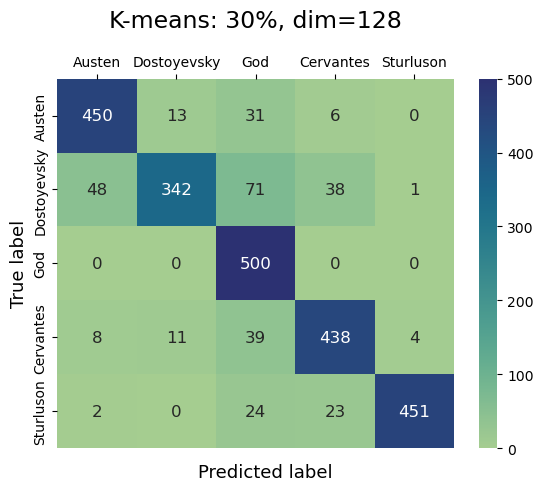

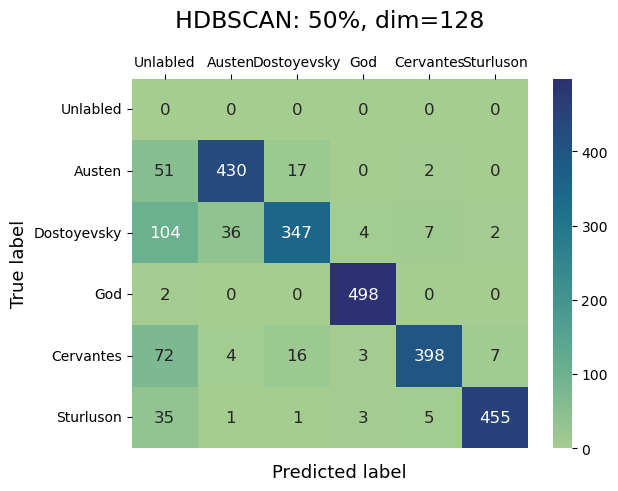

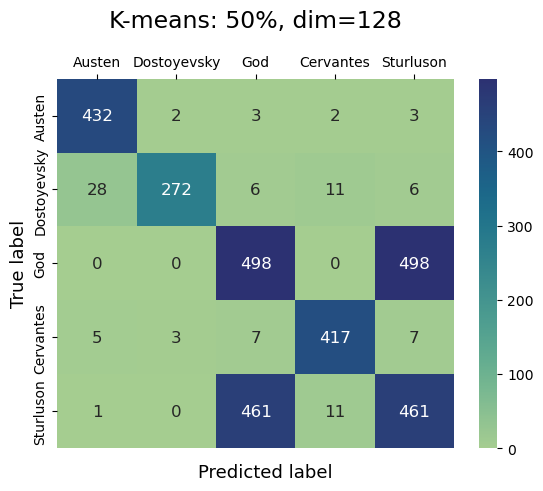

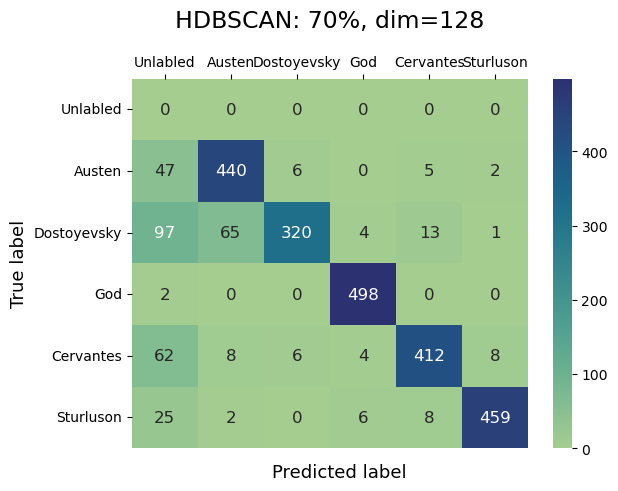

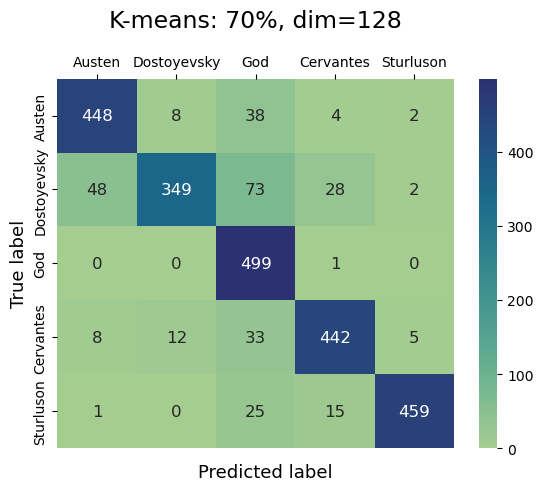

In [5]:
sizes = [2.5, 5, 7.5, 10]
dimensions = [2, 16, 128]

for idy, dim in enumerate(dimensions):
    print(f'Dimension: {dim}')
    for idx, size in enumerate(sizes):
        X_t2, X_val, y_t2, y_val = train_test_split(X_train, y_train, test_size=size/10, stratify=y_train, random_state=3)

        # reducing dimensions with labeled data (size*10 % training data)
        mapper = umap.UMAP(n_neighbors=30,
                            min_dist=0.0,
                            init='random',
                            metric='euclidean',
                            n_components=dim).fit(X_val, y=y_val)
        embedding_train = mapper.transform(X_train)
        embedding_test = mapper.transform(X_test)

        # fitting hdbscan and kmeans and plottig CMs
        hdb = hdbscan.HDBSCAN(
            min_cluster_size=500,
            min_samples=1,
            prediction_data=True
        ).fit(embedding_train)
        hdbpred, _strengths = hdbscan.approximate_predict(hdb, embedding_test)
        plot_confusion_matrix(sort_matrix(confusion_matrix(y_test, hdbpred)), f'HDBSCAN: {size*10}%, dim={dim}')
    
        kmeans = KMeans(n_clusters=5, random_state=3).fit(embedding_train)
        pred = kmeans.predict(embedding_test)
        plot_confusion_matrix(sort_matrix(confusion_matrix(y_test, pred)), f'K-means: {size*10}%, dim={dim}')



The clustering methods struggle particularily with Dostoyevsky (for sentences, unless they have a lot of labled data or are lucky with the dimensions - it seems that umap does not distinguish dostoyevsky well, NOTE that it is a nonsymmetric trouble!). This can be seen in our 2D UMAP visualisation.

Sometimes we get some impossible stuff happening / bugs/artifacts, where it classifies more things than exist, as if one datapoint has been classified multiple times...